In [ ]:
#@title ⬇️ Download Validation Data and Annotation & Setup SAM 3

# --- SAM 3 INSTALLATION (Added) ---
# We need the development version of transformers because SAM 3 is brand new (Nov 2025).
print("⚙️ Installing SAM 3 dependencies (transformers, accelerate, huggingface_hub)...")
!pip install -q --upgrade git+https://github.com/huggingface/transformers.git accelerate huggingface_hub
print("✅ SAM 3 Libraries installed.\n")
# ----------------------------------

import os, requests, zipfile

def download_and_unzip(url, extract_to, chain_path):
    """Download and unzip using a verified SSL certificate."""
    if os.path.exists(extract_to):
        print(f"The directory '{extract_to}' already exists. Skipping download and extraction.")
        return

    local_zip = os.path.basename(url)
    print(f"📥 Downloading {local_zip} (approx 1min)...")

    try:
        response = requests.get(url, stream=True, verify=chain_path, timeout=20)
        response.raise_for_status()
        with open(local_zip, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"✅ {local_zip} downloaded successfully ({os.path.getsize(local_zip)} bytes)")

        print(f"📂 Extracting to '{extract_to}/'...")
        os.makedirs(extract_to, exist_ok=True)
        with zipfile.ZipFile(local_zip, "r") as zip_ref:
            zip_ref.extractall(extract_to)
        os.remove(local_zip)
        print(f"✅ Extraction completed to '{extract_to}'")

    except requests.exceptions.RequestException as e:
        print(f"❌ Download error: {e}")
    except zipfile.BadZipFile:
        print("❌ The downloaded file is not a valid ZIP archive.")
    except Exception as e:
        print(f"⚠️ Unexpected error: {e}")

chain_path = "/content/chain-harica-cross.pem"
print("🔐 Downloading SSL certificate chain...")
cert_url = "https://pki.cesnet.cz/_media/certs/chain-harica-rsa-ov-crosssigned-root.pem"
r = requests.get(cert_url, timeout=10, stream=True)
r.raise_for_status()
with open(chain_path, "wb") as f:
    f.write(r.content)
print("✅ Certificate chain downloaded.\n")
zip_url = "https://su2.utia.cas.cz/files/labs/final2025/val_and_sota.zip"
extract_directory = "/content/val_data"
download_and_unzip(zip_url, extract_directory, chain_path)

print("\n🎯 All done!")

⚙️ Installing SAM 3 dependencies (transformers, accelerate, huggingface_hub)...
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.1/516.1 kB 13.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.1.2 requires transformers<5.0.0,>=4.41.0, but you have transformers 5.0.0.dev0 which is incompatible.
✅ SAM 3 Libraries installed.

🔐 Downloading SSL certificate chain...
✅ Certificate chain downloaded.

📥 Downloading val_and_sota.zip (approx 1min)...
✅ val_and_sota.zip downloaded successfully (452414908 bytes)
📂 Extracting to '/content/val_data/'...
✅ Extraction completed to '/content/val_data'

🎯 All done!


In [ ]:
#@title 🛠️ Setup (imports + funcs)

import matplotlib.animation as animation
from IPython.display import HTML, display, clear_output
import subprocess
import matplotlib as mpl
mpl.rcParams['animation.embed_limit'] = 150
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.collections as mc
import pandas as pd
from matplotlib.patches import Rectangle
from matplotlib.animation import FuncAnimation
from torch.utils.data import IterableDataset
from typing import Tuple, Union
from scipy.ndimage import gaussian_filter, maximum_filter
import ipywidgets as widgets
import math
from scipy import spatial, optimize
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torch_data
import time
import threading
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensure deterministic behavior in cuDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)



def open_tiff_file(name: str) -> np.ndarray:
    img = Image.open(name)

    frames = []
    for i in range(img.n_frames):
        img.seek(i)
        frames.append(np.array(img))

    return np.array(frames).squeeze()

def loading_html(message: str) -> str:
    return f"""
<div id="loading-msg">
  <br /><br />
  <b><span style='display:inline-block;animation:flipPause 2s ease infinite;'>⏳</span>
  {message}</b>
</div>
<style>
@keyframes flipPause {{
  0% {{transform:rotate(0deg);}}
  40%{{transform:rotate(180deg);}}
  50%{{transform:rotate(180deg);}}
  90%{{transform:rotate(360deg);}}
  100%{{transform:rotate(360deg);}}
}}
</style>
"""

html_code_reconstruction = loading_html("Showing input validation data, please wait...")

def replace_loading_js(message: str, delay_ms: int = 0) -> str:
    return f"""
<script>
  setTimeout(function(){{
    var loadingDiv = document.getElementById("loading-msg");
    if (loadingDiv) {{
      loadingDiv.innerHTML = '<br /><b>{message}</b>';
    }}
  }}, {delay_ms});
</script>
"""

replace_loading_js_default = replace_loading_js("Only the first 50 frames are displayed.")
replace_loading_js_empty = replace_loading_js("")


class OTF:
    """
    The Optical Transfer Function of the optical system.
    Generates a 2-D image from an exponential approximation of the ideal OTF.
    """

    def __init__(self, na: float, wavelength: float, pixel_size: float, image_size: int, curvature: float):
        """
        :param na: Numerical aperture of the optical system.
        :param wavelength: Wavelength of the emitted light in nanometers.
        :param pixel_size: Physical size of the image pixel in micrometers.
        :param image_size: Width and height of the image.
        :param curvature: Bend of the model OTF function in [0, 1] range where 1 is a perfect OTF.
        :param samples: Number of values to sample.
        """
        cutoff_frequency = 1000 * 2 * na / wavelength  # in micrometer^-1 (for incoherent imaging)
        self.image_cutoff = cutoff_frequency * pixel_size * image_size
        self.image_size = image_size
        self.curvature = curvature

    def __call__(self, size: int = None, x_shift: float = 0, y_shift: float = 0) -> np.ndarray:
        """
        Generate a 2-D image representation.
        :param size: Width and height of the generated image.
        :param x_shift: Sub-pixel shift along the x-axis of the OTF center.
        :param y_shift:Sub-pixel shift along the y-axis of the OTF center.
        :return: 2-D representation of the OTF
        """
        if size is None:
            size = self.image_size

        x, y = np.meshgrid(np.hstack([np.arange(size // 2), np.arange(-size // 2, 0)]),
                           np.hstack([np.arange(size // 2), np.arange(-size // 2, 0)]))
        distance_to_origin = np.hypot(x + x_shift, y + y_shift)

        return self.value(np.minimum(distance_to_origin / self.image_cutoff, 1))

    def double(self, x_shift: float = 0, y_shift: float = 0) -> np.ndarray:
        return self(self.image_size * 2, x_shift, y_shift)

    def value(self, x):
        return (2 / np.pi) * (np.arccos(x) - x * np.sqrt(1 - x * x)) * self.curvature ** x

def apodization_filter(dist_ratio: float, bend: float, size: int) -> np.ndarray:
    """
    Generate an apodization filter that can be directly multiplied with the summed fft result image.

    :param dist_ratio: A coefficient that transform the point distance in pixels to a value where [0, 1] range
        corresponds to the extended OTF support.
    :param bend: A coefficient in the [0, 1] range defining how much medium frequencies should be augmented.
    :param size: Size of the apodization filter.
    :return: np.ndarray of size (size, size) of the apodization filter.
    """
    x, y = np.meshgrid(np.hstack([np.arange(size // 2), np.arange(-size // 2, 0)]),
                       np.hstack([np.arange(size // 2), np.arange(-size // 2, 0)]))

    distance = np.hypot(x, y) * dist_ratio
    mask = np.bitwise_and(0 <= distance, distance < 1)

    apo = np.power(
        (2 / np.pi) * (np.arccos(distance, where=mask) - distance * np.sqrt(1 - distance * distance, where=mask)),
        bend,
        where=mask
    )

    return np.where(mask, apo, 0)


def wiener_filter(shifts, otf: OTF, w: float, size: int) -> np.ndarray:
    """
    Generate a wiener filter denominator so that it can be directly multiplied with the summed fft result image.

    :param shifts: A container of length 3 of shifts of the second component for each of the 3 orientations.
    :param otf: OTF object.
    :param w: Wiener parameter.
    :param size: Size of the wiener filter.
    :return: np.ndarray of size (size, size) of the Wiener filter denominator.
    """
    otf0 = np.abs(otf(size)) ** 2
    wiener = 3 * otf0

    for i in range(3):
        otf1 = np.abs(otf(size, shifts[i][1], shifts[i][0])) ** 2
        otf2 = np.abs(otf(size, -shifts[i][1], -shifts[i][0])) ** 2

        wiener += otf1 + otf2

    return 1 / (wiener + w * w)

def map_otf_support(components: np.ndarray, shifts, otf: OTF) -> None:
    """
    Multiply conjugated OTF to corresponding parts of it's support in the separated and shifted components. Values
    outside the OTF support are set to zero. This function alters the original images.

    :param components: np.ndarray of shape (9, size, size) of padded separated and shifted components in frequency space.
    :param shifts: A container of length 3 of shifts of the second component for each of the 3 orientations.
    :param otf: OTF object
    """
    size = components.shape[-1]

    components[::3] *= np.conjugate(otf(size))
    for i in range(3):
        components[i * 3 + 1] *= np.conjugate(otf(size, shifts[i][1], shifts[i][0]))
        components[i * 3 + 2] *= np.conjugate(otf(size, -shifts[i][1], -shifts[i][0]))


def fourier_shift(fft_image: np.ndarray, x_shift: Union[float, np.ndarray], y_shift: Union[float, np.ndarray]) -> np.ndarray:
    """
    Use the fourier shift theorem to perform a sub-pixel shift of a frequency image in the spatial domain.

    It is implemented in a way that allows the x_shift and y_shift parameters to be a np.ndarray of arbitrary shape with
    the last two axes being np.newaxis or None. The returned array shape is then x/y_shift.shape + (height, width)

    :param fft_image: np.ndarray of shape (height, width).
    :param x_shift: Sub-pixel shift along the x-axis.
    :param y_shift: Sub-pixel shift along the y-axis.
    :return: np.ndarray of shape (height, width) of the shifted frequency image.
    """
    height, width = fft_image.shape[-2:]

    spatial_image = np.fft.ifft2(fft_image)

    x_indices = np.arange(-width // 2, width // 2, dtype=int)
    y_indices = np.arange(-height // 2, height // 2, dtype=int)

    x = np.exp(-1j * 2 * np.pi * x_shift * x_indices[None, :] / width)
    y = np.exp(-1j * 2 * np.pi * y_shift * y_indices[:, None] / height)

    shifted_spatial_image = spatial_image * (x * y)

    return np.fft.fft2(shifted_spatial_image)


def shift_components(components: np.ndarray, shifts) -> None:
    """
    Use the fourier shift theorem to perform a sub-pixel shift of frequency components in the spatial domain. This
    function alters the original images.

    :param components: np.ndarray of shape (9, height, width) of padded separated components in frequency space.
    :param shifts: A container of length 3 of shifts of the second component for each of the 3 orientations.
    :return: np.ndarray of shape (9, height, width) of shifted components.
    """
    for i in range(3):
        components[i * 3 + 1, ...] = fourier_shift(components[i * 3 + 1, ...], shifts[i][1], shifts[i][0])
        components[i * 3 + 2, ...] = fourier_shift(components[i * 3 + 2, ...], -shifts[i][1], -shifts[i][0])


def pad_components(components: np.ndarray) -> np.ndarray:
    """
    Pad an image to twice its size from the center, keeping the corners intact.
    This makes it possible to pad images that are NOT centered using np.fft.fftshift.

    :param components: np.ndarray of shape (..., size, size) of separated components in frequency space.
    :return: np.ndarray of shape (..., size, size) padded with zeros from the center.
    """
    size = components.shape[-1]
    padded_components = np.zeros(components.shape[:-2] + (size * 2, size * 2), dtype=np.complex128)

    x, y = np.meshgrid(
        np.hstack([np.arange(size // 2), np.arange(size * 3 // 2, size * 2)]),
        np.hstack([np.arange(size // 2), np.arange(size * 3 // 2, size * 2)])
    )

    padded_components[..., y, x] = components

    return padded_components

def _component_separation_matrix(phase_offset: float = 0, modulation: float = 1) -> np.ndarray:
    phases = np.array([0, 2 * np.pi / 3, 4 * np.pi / 3]) + phase_offset

    M = np.ones((3, 3), dtype=np.complex128)


    M[:, 1] = 0.5 * modulation * (np.cos(phases) + 1j * np.sin(phases))
    M[:, 2] = 0.5 * modulation * (np.cos(-phases) + 1j * np.sin(-phases))

    return np.linalg.inv(M)

def separate_components(fft_images: np.ndarray, phase_offsets=np.zeros(3), phase_modulations=np.ones(3)) -> np.ndarray:
    """
    Compute the spectral separation of components.

    :param fft_images: np.ndarray of shape (9, height, width) of images in frequency space.
    :param phase_offsets: A container of length 3 of phase offsets for each of the 3 orientations, zeros by default.
    :param phase_modulations: A container of length 3 of phase modulations for each of the 3 orientations,
        ones by default.
    :return: np.ndarray of shape (9, height, width) of separated components.
    """
    separation_matrices = np.array([_component_separation_matrix(phase_offsets[i], phase_modulations[i])
                                    for i in range(3)])

    return np.einsum('aij,ajkl->aikl',separation_matrices,
                     fft_images.reshape(3, 3, *fft_images.shape[1:])).reshape(9, *fft_images.shape[1:])


def run_reconstruction(fft_images: np.ndarray, otf: OTF, shifts, phase_offsets, modulations, config: dict) -> Tuple[np.ndarray, np.ndarray]:
    """
    Perform a SIM reconstruction using the provided parameters.

    :param fft_images: np.ndarray of shape (9, height, width) of images in frequency space.
    :param otf: OTF object
    :param shifts: A container of length 3 of shifts of the second component for each of the 3 orientations.
    :param phase_offsets: A container of length 3 of phase offsets for each of the 3 orientations.
    :param modulations: A container of length 3 of phase modulations for each of the 3 orientations.
    :param config: A dictionary of SIM reconstruction parameters. It must contain the following keys: ["wavelength",
        "na", "px_size", "apo_cutoff", "wiener_parameter", "apo_bend"]
    :return: fft_result, spatial_result
    """
    size = fft_images.shape[-1]
    cutoff = 1000 * 2 * config["na"] / config["wavelength"]
    apo_dist_ratio = 1 / (config["px_size"] * config["apo_cutoff"] * cutoff * size)

    components = separate_components(fft_images, phase_offsets, modulations)
    components = pad_components(components)

    shift_components(components, shifts)
    map_otf_support(components, shifts, otf)

    wiener = wiener_filter(shifts, otf, config["wiener_parameter"], size * 2)
    apodization = apodization_filter(apo_dist_ratio, config["apo_bend"], size * 2)

    fft_result = np.sum(components, 0) * wiener * apodization
    spatial_result = np.real(np.fft.ifft2(fft_result))

    return fft_result, spatial_result

def illumination_pattern(angle, frequency, phase_offset, amplitude, size) -> np.ndarray:
    n = size // 2
    Y, X = np.mgrid[-n:n, -n:n]
    ky, kx = np.sin(angle) * frequency, np.cos(angle) * frequency
    return 1 + amplitude * np.cos(2 * np.pi * (X * kx + Y * ky) + phase_offset)


class PerlinNoise:
    """Adapted from: https://github.com/pvigier/perlin-numpy"""

    def __init__(self, size: int, res: int):
        """
        :param size: length of both dimensions of the generated noise image
        :param res: number of periods of noise to generate along each axis
        """

        meshgrid = np.mgrid[0:res:res / size, 0:res:res / size]
        self.grid = np.stack(meshgrid) % 1

        self.t = self._fade(self.grid)
        self.d = size // res
        self.sample_size = (res + 1, res + 1)

    def __call__(self) -> np.array:
        """
        Returned values are always in the [0, 1] range with ~0.5 mean
        """
        angles = 2 * np.pi * np.random.random_sample(self.sample_size)
        gradients = np.dstack((np.cos(angles), np.sin(angles))).repeat(self.d, 0).repeat(self.d, 1)

        n00 = (np.dstack((self.grid[0], self.grid[1])) * gradients[:-self.d, :-self.d]).sum(2)
        n10 = (np.dstack((self.grid[0] - 1, self.grid[1])) * gradients[self.d:, :-self.d]).sum(2)
        n01 = (np.dstack((self.grid[0], self.grid[1] - 1)) * gradients[:-self.d, self.d:]).sum(2)
        n11 = (np.dstack((self.grid[0] - 1, self.grid[1] - 1)) * gradients[self.d:, self.d:]).sum(2)

        n0 = n00 * (1 - self.t[0]) + n10 * self.t[0]
        n1 = n01 * (1 - self.t[0]) + n11 * self.t[0]

        return 0.5 + 2 ** -0.5 * (n0 * (1 - self.t[1]) + n1 * self.t[1])

    @staticmethod
    def _fade(t):
        return 6 * t ** 5 - 15 * t ** 4 + 10 * t ** 3


class SyntheticDataset(IterableDataset):
    def __init__(self, contrast_fg_range: tuple[float,float] = (0.0, 1.0), contrast_bg_range: tuple[float,float] = (0.0, 1.0)):
        self.patch_size = 128

        self.contrast_fg_range = contrast_fg_range
        self.contrast_bg_range = contrast_bg_range

        self.frequency = 0.17
        self.amplitude = 1.0

        self.config = {
            "na": 1.49,
            "wavelength": 512,
            "px_size": 0.07,
            "wiener_parameter": 0.1,
            "apo_cutoff": 2.0,
            "apo_bend": 0.9
        }

        self.otf = OTF(self.config['na'], self.config['wavelength'], self.config['px_size'], self.patch_size // 2, 0.3)
        self.otf_mult = self.otf(self.patch_size)

        self.perlin = PerlinNoise(self.patch_size, 1)

    def _simulate_sim(self, image):
        angle0 = np.random.uniform(0, np.pi * 2)
        phase_offsets = np.random.uniform(0, np.pi * 2, 3)

        shifts = [(self.frequency * self.patch_size * np.sin(angle0 + i * np.pi / 3),
                   self.frequency * self.patch_size * np.cos(angle0 + i * np.pi / 3))
                  for i in range(3)]

        illumination = np.stack([illumination_pattern(angle0 + i // 3 * np.pi / 3,
                                                      self.frequency,
                                                      phase_offsets[i // 3] + (i % 3) * np.pi * 2 / 3,
                                                      self.amplitude,
                                                      self.patch_size)
                                 for i in range(9)])


        fg_c = np.random.uniform(*self.contrast_fg_range)
        bg_c = np.random.uniform(*self.contrast_bg_range)
        foreground = 250 + fg_c * 500
        background = 50 + bg_c * 50

        high_res_image = (image * foreground + background) * self.perlin()

        ix = np.fft.fft2(illumination * high_res_image)
        hix = self.otf_mult * ix
        dhix = hix.reshape(9, 2, self.patch_size // 2, 2, self.patch_size // 2).sum((1, 3)) / 4
        low_res_images = np.random.poisson(np.fft.ifft2(dhix).real).astype(np.float64)

        noisy_shifts = [np.random.triangular((y - 0.25, x - 0.25), (y, x), (y + 0.25, x + 0.25)) for y, x in shifts]
        noisy_phase_offsets = np.random.normal(phase_offsets, np.pi / 6)
        noisy_amplitudes = np.random.normal(self.amplitude, 0.1, 3)

        reconstruction = run_reconstruction(np.fft.fft2(low_res_images), self.otf, noisy_shifts, noisy_phase_offsets, noisy_amplitudes, self.config)[1]
        return (reconstruction - np.mean(reconstruction)) / np.std(reconstruction)

class SyntheticCCPDataset(SyntheticDataset):
    def __init__(self,min_n: int = 5, max_n: int = 15, radius: float = 2.5,
        contrast_fg_range: tuple[float,float] = (0.0, 1.0),
        contrast_bg_range: tuple[float,float] = (0.0, 1.0)):
        super().__init__(
            contrast_fg_range=contrast_fg_range,
            contrast_bg_range=contrast_bg_range
        )

        self.patch_size = 128

        # Possible positions
        yy, xx = np.mgrid[15:self.patch_size - 1:16, 15:self.patch_size - 1:16]
        self.yy = yy.flatten()
        self.xx = xx.flatten()

        # validate
        if not (0 <= min_n < max_n <= 49):
            raise ValueError("Require 0 <= min_n < max_n <= 49")
        self.min_n, self.max_n = min_n, max_n

        self.max_offset = 8
        assert self.max_offset < 16

        # Beta params
        self.beta_a = 2
        self.beta_b = 1

        # CCP shape params
        self.radius = radius
        self.thickness = 1.0

        # Patch positions
        self.yyy, self.xxx = np.mgrid[:self.patch_size, :self.patch_size]

    def __iter__(self):
        while True:
            yield self.data_sample()

    def data_sample(self):
        # Generate positions and classes
        n = np.random.randint(self.min_n, self.max_n)
        indices = np.random.choice(len(self.yy), size=n, replace=False)
        offsets = np.random.uniform(-self.max_offset, self.max_offset, (n, 2))
        positions = np.column_stack([self.yy[indices], self.xx[indices]]) + offsets
        classes = np.random.beta(self.beta_a, self.beta_b, n) * 0.9 + 0.1

        # Generate simulated HR image and output target
        target_distance = classes * self.radius
        distance = np.hypot(self.yyy[..., None] - positions[:, 0], self.xxx[..., None] - positions[:, 1])
        abs_distance = np.abs(distance - target_distance)
        parts = np.where(abs_distance > self.thickness, 0, np.log(np.interp(abs_distance / self.thickness, [0, 1], [np.e, 1])))
        full_image = np.sum(parts, -1)

        distances = np.maximum(classes - distance / ((1 - classes) * 2 + self.radius + self.thickness * 2), 0)
        y = np.minimum(np.sum(distances, -1), 1)

        # Generate simulated SIM image
        x = super()._simulate_sim(full_image)

        return x, y

def hota(gt: pd.DataFrame, tr: pd.DataFrame, threshold: float = 5) -> dict[str, float]:
    """Slightly adapted from https://github.com/JonathonLuiten/TrackEval"""

    # Ensure particle ids are sorted from 0 to max(n)
    gt = gt.copy()
    tr = tr.copy()

    gt.track_id = gt.track_id.map({old: new for old, new in zip(gt.track_id.unique(), range(gt.track_id.nunique()))})
    tr.track_id = tr.track_id.map({old: new for old, new in zip(tr.track_id.unique(), range(tr.track_id.nunique()))})

    # Initialization
    num_gt_ids = gt.track_id.nunique()
    num_tr_ids = tr.track_id.nunique()

    frames = sorted(set(gt.frame.unique()) | set(tr.frame.unique()))

    potential_matches_count = np.zeros((num_gt_ids, num_tr_ids))
    gt_id_count = np.zeros((num_gt_ids, 1))
    tracker_id_count = np.zeros((1, num_tr_ids))

    HOTA_TP, HOTA_FN, HOTA_FP = 0, 0, 0
    LocA = 0.0

    # Compute similarities (inverted normalized distance)
    similarities = [1 - np.clip(spatial.distance.cdist(gt[gt.frame == t][['x', 'y']],
                                                       tr[tr.frame == t][['x', 'y']]) / threshold, 0, 1)
                    for t in frames]

    # Accumulate global track information
    for t in frames:
        gt_ids_t = gt[gt.frame == t].track_id.to_numpy()
        tr_ids_t = tr[tr.frame == t].track_id.to_numpy()

        similarity = similarities[t]
        sim_iou_denom = similarity.sum(0)[np.newaxis, :] + similarity.sum(1)[:, np.newaxis] - similarity
        sim_iou = np.zeros_like(similarity)
        sim_iou_mask = sim_iou_denom > 0 + np.finfo('float').eps
        sim_iou[sim_iou_mask] = similarity[sim_iou_mask] / sim_iou_denom[sim_iou_mask]
        potential_matches_count[gt_ids_t[:, None], tr_ids_t[None, :]] += sim_iou

        gt_id_count[gt_ids_t] += 1
        tracker_id_count[0, tr_ids_t] += 1

    global_alignment_score = potential_matches_count / (gt_id_count + tracker_id_count - potential_matches_count)
    matches_count = np.zeros_like(potential_matches_count)

    # Calculate scores for each timestep
    for t in frames:
        gt_ids_t = gt[gt.frame == t].track_id.to_numpy()
        tr_ids_t = tr[tr.frame == t].track_id.to_numpy()

        if len(gt_ids_t) == 0:
            HOTA_FP += len(tr_ids_t)
            continue

        if len(tr_ids_t) == 0:
            HOTA_FN += len(gt_ids_t)
            continue

        similarity = similarities[t]
        score_mat = global_alignment_score[gt_ids_t[:, None], tr_ids_t[None, :]] * similarity

        match_rows, match_cols = optimize.linear_sum_assignment(-score_mat)

        actually_matched_mask = similarity[match_rows, match_cols] > 0
        alpha_match_rows = match_rows[actually_matched_mask]
        alpha_match_cols = match_cols[actually_matched_mask]

        num_matches = len(alpha_match_rows)

        HOTA_TP += num_matches
        HOTA_FN += len(gt_ids_t) - num_matches
        HOTA_FP += len(tr_ids_t) - num_matches

        if num_matches > 0:
            LocA += sum(similarity[alpha_match_rows, alpha_match_cols])
            matches_count[gt_ids_t[alpha_match_rows], tr_ids_t[alpha_match_cols]] += 1

    ass_a = matches_count / np.maximum(1, gt_id_count + tracker_id_count - matches_count)
    AssA = np.sum(matches_count * ass_a) / np.maximum(1, HOTA_TP)
    DetA = HOTA_TP / np.maximum(1, HOTA_TP + HOTA_FN + HOTA_FP)
    HOTA = np.sqrt(DetA * AssA)

    return {'HOTA': HOTA, 'AssA': AssA, 'DetA': DetA, 'LocA': LocA,
            'HOTA TP': HOTA_TP, 'HOTA FN': HOTA_FN, 'HOTA FP': HOTA_FP}


def link_detections(detections_per_frame: list[list[tuple[int, int]]],
                    max_dist: float = 7.0) -> pd.DataFrame:
    """Link detections across frames into tracks using nearest neighbour association.

    Args:
        detections_per_frame: a list where each element is a list of (x,y)
            detections for the corresponding frame index.
        max_dist: maximum allowed distance in pixels between a detection and
            an existing track’s last position for association.  If no
            detection falls within this radius the track is terminated and
            a new track is started for the unmatched detection.

    Returns:
        A pandas DataFrame with columns ['frame','x','y','track_id'] containing
        the linked tracks.
    """
    next_track_id = 0
    active_tracks: dict[int, tuple[int, int, int]] = {}  # track_id -> (x, y, last_frame)
    records: list[dict[str, int]] = []
    for frame_idx, detections in enumerate(detections_per_frame):
        assigned = [False] * len(detections)
        detection_track_id: list[int | None] = [None] * len(detections)
        updated_tracks: dict[int, tuple[int, int, int]] = {}
        # attempt to match existing tracks to current detections
        for track_id, (tx, ty, last_frame) in list(active_tracks.items()):
            best_dist = max_dist
            best_idx: int | None = None
            for i, (x, y) in enumerate(detections):
                if assigned[i]:
                    continue
                dist = math.hypot(x - tx, y - ty)
                if dist < best_dist:
                    best_dist = dist
                    best_idx = i
            if best_idx is not None:
                # assign detection to this track
                assigned[best_idx] = True
                detection_track_id[best_idx] = track_id
                updated_tracks[track_id] = (detections[best_idx][0], detections[best_idx][1], frame_idx)
            # tracks with no assignment are dropped (no occlusion handling)
        # start new tracks for unmatched detections
        for i, (x, y) in enumerate(detections):
            if not assigned[i]:
                track_id = next_track_id
                next_track_id += 1
                detection_track_id[i] = track_id
                updated_tracks[track_id] = (x, y, frame_idx)
        # update active tracks
        active_tracks = updated_tracks
        # record detections with assigned track ids
        for i, (x, y) in enumerate(detections):
            tid = detection_track_id[i]
            records.append({'frame': frame_idx, 'x': x, 'y': y, 'track_id': tid})
    return pd.DataFrame(records)


def show_tracking(data, image_stack,
                  y_min=512, y_max=768, x_min=256, x_max=512,
                  tail_length=10, color='yellow', show_roi=True):
    """
    Visualize CCP trajectories within a defined ROI, from either a CSV file or a DataFrame.

    Args:
        data (str | pd.DataFrame): Path to CSV file or a DataFrame containing trajectories.
        image_stack (np.ndarray): 3D numpy array (frames, height, width).
        y_min, y_max, x_min, x_max (int): ROI bounds.
        tail_length (int): Number of frames for trajectory tails.
        color (str): Trajectory color.
        show_roi (bool): Whether to display cyan ROI rectangle on the full frame.
    """

    if isinstance(data, str):
        trajectories_df = pd.read_csv(data)
    elif isinstance(data, pd.DataFrame):
        trajectories_df = data.copy()
    else:
        raise TypeError("`data` must be a CSV file path or a pandas DataFrame.")

    tracks_in_roi = trajectories_df.groupby('track_id').filter(
        lambda t: (y_min < t.y.mean() < y_max) and (x_min < t.x.mean() < x_max)
    )

    html_code_linking = loading_html("Loading cropped region and tracks, please wait...")
    display(HTML(html_code_linking))

    if show_roi:
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(image_stack[0], cmap='magma')
        rect = Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                         linewidth=2, edgecolor='cyan', facecolor='none')
        ax.add_patch(rect)
        ax.set_title("Full image (cyan box shows cropped region)")
        plt.show()

    def animate_trajectories_cropped(trajectories_df, image_stack, tail_length=10, color='yellow'):
        cropped_stack = image_stack[:, y_min:y_max, x_min:x_max]

        fig, ax = plt.subplots()
        im = ax.imshow(cropped_stack[0], cmap='magma')
        particles = trajectories_df['track_id'].unique()

        line_collections = {pid: mc.LineCollection([], linewidths=1, colors=color) for pid in particles}
        for lc in line_collections.values():
            ax.add_collection(lc)

        dot = ax.scatter([], [], s=5, c=color)

        def animate(i):
            im.set_array(cropped_stack[i])

            window = trajectories_df[
                (trajectories_df['frame'] >= i - tail_length) &
                (trajectories_df['frame'] <= i)
            ]

            now = window[window['frame'] == i]
            if len(now) > 0:
                coords = np.column_stack((now.x.values - x_min, now.y.values - y_min))
                dot.set_offsets(coords)
            else:
                dot.set_offsets(np.empty((0, 2)))

            for pid in particles:
                traj = window[window['track_id'] == pid].sort_values('frame')
                if len(traj) >= 2:
                    segs = [
                        [(x0 - x_min, y0 - y_min), (x1 - x_min, y1 - y_min)]
                        for (x0, y0, x1, y1) in zip(
                            traj.x.values[:-1], traj.y.values[:-1],
                            traj.x.values[1:], traj.y.values[1:]
                        )
                    ]
                    line_collections[pid].set_segments(segs)
                else:
                    line_collections[pid].set_segments([])

            return [im, dot] + list(line_collections.values())

        ani = FuncAnimation(fig, animate, frames=cropped_stack.shape[0], interval=100, blit=True)
        plt.close(fig)
        return HTML(ani.to_jshtml())

    html = animate_trajectories_cropped(tracks_in_roi, image_stack, tail_length, color)
    display(html)
    display(HTML(replace_loading_js_empty))

    print("Total number of trajectories in ROI:", len(tracks_in_roi['track_id'].unique()))


def visualize_model_on_dataset(model, dataset, device, num_samples=4, threshold=0.5, sigma=1.0):
    """
    Visualize model predictions on a few samples from the dataset.
    Shows: input image, ground truth mask, predicted probability map, and binary detection mask.
    """
    model.eval()
    loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

    with torch.no_grad():
        for i, (img_tensor, mask_tensor) in enumerate(loader):
            if i >= num_samples:
                break

            img_tensor = img_tensor.to(device)
            mask_tensor = mask_tensor.to(device)

            # Run through model
            logits = model(img_tensor)
            prob_map = torch.sigmoid(logits[0, 0]).cpu().numpy()

            # Optional smoothing
            if sigma > 0:
                prob_map = gaussian_filter(prob_map, sigma=sigma)

            # Threshold for binary detection
            pred_mask = (prob_map >= threshold).astype(float)

            img = img_tensor[0, 0].cpu().numpy()
            gt_mask = mask_tensor[0, 0].cpu().numpy()

            fig, axes = plt.subplots(1, 4, figsize=(14, 4))
            axes[0].imshow(img, cmap='magma')
            axes[0].set_title("Input Image")
            axes[1].imshow(gt_mask, cmap='gray', vmin=0, vmax=1)
            axes[1].set_title("Ground Truth Mask")
            axes[2].imshow(prob_map, cmap='viridis')
            axes[2].set_title("Predicted Heatmap")
            axes[3].imshow(pred_mask, cmap='gray', vmin=0, vmax=1)
            axes[3].set_title(f"Thresholded Output (>{threshold})")
            for ax in axes:
                ax.axis('off')
            plt.tight_layout()
            plt.show()


def show_detections(detections_per_frame, image_stack,
                    y_min=512, y_max=768, x_min=256, x_max=512,
                    color='yellow', max_frames=5):
    """
    Visualize detections in the specified ROI.

    Args:
        detections_per_frame (list[list[tuple]]): List of per-frame detection coordinates [(x, y)].
        image_stack (np.ndarray): Image sequence (frames, height, width).
        y_min, y_max, x_min, x_max (int): ROI bounds.
        color (str): Color of detection markers.
        max_frames (int): Number of frames to animate (default: 5).
    """

    rows = [(frame_idx, x, y)
            for frame_idx, dets in enumerate(detections_per_frame)
            for (x, y) in dets]
    detections_df = pd.DataFrame(rows, columns=["frame", "x", "y"])

    detections_df = detections_df[
        (detections_df.y.between(y_min, y_max)) &
        (detections_df.x.between(x_min, x_max))
    ]

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(image_stack[0], cmap='magma')
    rect = Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                     linewidth=2, edgecolor='cyan', facecolor='none')
    ax.add_patch(rect)
    ax.set_title("Full image (cyan box shows cropped region)")
    plt.show()

    def animate_detections_cropped(detections_df, image_stack, color='yellow'):
        cropped_stack = image_stack[:, y_min:y_max, x_min:x_max]

        fig, ax = plt.subplots()
        im = ax.imshow(cropped_stack[0], cmap='magma')
        dot = ax.scatter([], [], s=10, c=color)

        def animate(i):
            im.set_array(cropped_stack[i])
            now = detections_df[detections_df['frame'] == i]
            if len(now) > 0:
                coords = np.column_stack((now.x.values - x_min, now.y.values - y_min))
                dot.set_offsets(coords)
            else:
                dot.set_offsets(np.empty((0, 2)))
            return [im, dot]

        ani = FuncAnimation(fig, animate,
                            frames=min(max_frames, cropped_stack.shape[0]),
                            interval=1000, blit=True)
        plt.close(fig)
        return HTML(ani.to_jshtml())

    html = animate_detections_cropped(detections_df, np.array(image_stack), color)
    display(html)

    print(f"Total detections in ROI : {len(detections_df)} \nShowing first {max_frames} frames")



def calculate_performance(gt_path, tracks,
                          y_min=512, y_max=768, x_min=256, x_max=512,
                          name="Method"):
    """
    Calculate and print HOTA-based performance metrics for a tracking result.

    Args:
        gt_path (str): Path to ground truth CSV file.
        tracks (str | pd.DataFrame): Tracking results (as DataFrame or CSV path).
        y_min, y_max, x_min, x_max (int): ROI bounds.
        name (str): Name of the method (for display).
    """

    val_gt = pd.read_csv(gt_path)
    val_gt = val_gt.groupby('track_id').filter(
        lambda t: (y_min < t.y.mean() < y_max) and (x_min < t.x.mean() < x_max)
    )

    if isinstance(tracks, str):
        val_tracks = pd.read_csv(tracks)
    elif isinstance(tracks, pd.DataFrame):
        val_tracks = tracks.copy()
    else:
        raise TypeError("`tracks` must be a CSV path or a pandas DataFrame.")

    val_tracks = val_tracks.groupby('track_id').filter(
        lambda t: (y_min < t.y.mean() < y_max) and (x_min < t.x.mean() < x_max)
    )

    # Compute metrics
    results = hota(val_gt, val_tracks)

    print(f"{name}:")
    print(f"  HOTA: {results['HOTA']:.2f} "
          f"(AssA: {results['AssA']:.2f}, DetA: {results['DetA']:.2f})\n")

    return results

    print(f"✅ Done")

In [ ]:
#@title ⬇️ Setup, Download Data & Run SAM 3 Evaluation
import sys

# 1. INSTALLATION: Upgrade transformers for SAM 3 support (Nov 2025 version)
print("⚙️ Installing SAM 3 dependencies...")
!pip install -q --upgrade git+https://github.com/huggingface/transformers.git accelerate huggingface_hub pandas scipy tifffile

import os
import requests
import zipfile
import torch
import numpy as np
import pandas as pd
import tifffile
from PIL import Image
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment
from scipy.ndimage import center_of_mass, label
from google.colab import userdata
from huggingface_hub import login
from transformers import Sam3Processor, Sam3Model

# ---------------------------------------------------------
# 2. DATA DOWNLOAD (User Provided Logic)
# ---------------------------------------------------------
def download_and_unzip(url, extract_to, chain_path):
    """Download and unzip using a verified SSL certificate."""
    if os.path.exists(extract_to):
        print(f"The directory '{extract_to}' already exists. Skipping download.")
        return

    local_zip = os.path.basename(url)
    print(f"📥 Downloading {local_zip} (approx 1min)...")

    try:
        response = requests.get(url, stream=True, verify=chain_path, timeout=20)
        response.raise_for_status()
        with open(local_zip, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"✅ Downloaded {os.path.getsize(local_zip)} bytes")

        print(f"📂 Extracting to '{extract_to}/'...")
        os.makedirs(extract_to, exist_ok=True)
        with zipfile.ZipFile(local_zip, "r") as zip_ref:
            zip_ref.extractall(extract_to)
        os.remove(local_zip)
        print(f"✅ Extraction completed.")

    except Exception as e:
        print(f"❌ Error: {e}")

chain_path = "/content/chain-harica-cross.pem"
if not os.path.exists(chain_path):
    print("🔐 Downloading SSL certificate chain...")
    r = requests.get("https://pki.cesnet.cz/_media/certs/chain-harica-rsa-ov-crosssigned-root.pem", timeout=10)
    with open(chain_path, "wb") as f: f.write(r.content)

download_and_unzip("https://su2.utia.cas.cz/files/labs/final2025/val_and_sota.zip", "/content/val_data", chain_path)

# ---------------------------------------------------------
# 3. AUTHENTICATION (Using Colab Secrets)
# ---------------------------------------------------------
try:
    # Ensure you have added 'HF_TOKEN' to the "Keys" (Secrets) icon on the left sidebar
    hf_token = userdata.get('HF_TOKEN')
    login(token=hf_token, add_to_git_credential=True)
    print("✅ Logged in to Hugging Face successfully.")
except Exception as e:
    print(f"⚠️ Authentication Failed: {e}")
    print("Please add 'HF_TOKEN' to Colab Secrets (Key icon on left).")

⚙️ Installing SAM 3 dependencies...
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 54.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
The directory '/content/val_data' already exists. Skipping download.
✅ Logged in to Hugging Face successfully.


In [ ]:
def process_and_split_mask(sam_mask, score, crop_uint8, min_area, pixel_thresh, border_margin=10):
    """
    Splits fused masks, filters by Area + Intensity, AND removes edge artifacts.
    """
    valid_points = []
    if sam_mask.sum() <= 0: return []

    h, w = crop_uint8.shape[:2] # Get dimensions of the crop

    # Distance Transform & Watershed
    distance = ndi.distance_transform_edt(sam_mask)
    coords = peak_local_max(distance, min_distance=3, labels=sam_mask)

    mask_peaks = np.zeros(distance.shape, dtype=bool)
    mask_peaks[tuple(coords.T)] = True
    markers, _ = ndi.label(mask_peaks)

    labels = watershed(-distance, markers, mask=sam_mask)

    for label_id in np.unique(labels):
        if label_id == 0: continue

        sub_mask = (labels == label_id)

        # A. Area Filter
        if sub_mask.sum() < min_area: continue

        # B. Get Center
        y, x = center_of_mass(sub_mask)
        if np.isnan(x) or np.isnan(y): continue

        # --- NEW: C. BORDER FILTER ---
        # If the center is too close to any edge, kill it.
        if (x < border_margin) or (x > w - border_margin) or \
           (y < border_margin) or (y > h - border_margin):
            continue

        # D. Intensity Filter
        y_int, x_int = int(y), int(x)
        if 0 <= y_int < h and 0 <= x_int < w:
            brightness = crop_uint8[y_int, x_int]
            if brightness < pixel_thresh:
                continue

        valid_points.append({'x': x, 'y': y, 'score': score})

    return valid_points

In [ ]:
import tifffile
import os
import numpy as np

# 1. Define the path
tiff_path = "/content/val_data/val.tif"

# 2. Load the file into the variable 'video_stack'
if os.path.exists(tiff_path):
    video_stack = tifffile.imread(tiff_path)
    print(f"✅ Loaded video_stack with shape: {video_stack.shape}")
    print(f"   (Frames: {video_stack.shape[0]}, Height: {video_stack.shape[1]}, Width: {video_stack.shape[2]})")
else:
    raise FileNotFoundError(f"❌ Could not find file at: {tiff_path}")

✅ Loaded video_stack with shape: (120, 1024, 1024)
   (Frames: 120, Height: 1024, Width: 1024)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import ipywidgets as widgets
from IPython.display import display

# 1. Define the Coordinates explicitly for comparison
# Original (Old)
orig_x_min, orig_x_max = 256, 512
orig_y_min, orig_y_max = 512, 768

# Current (New) - ensuring these are in globals for the script
if 'roi_x_min' not in globals():
    roi_x_min, roi_x_max = 384, 640
    roi_y_min, roi_y_max = 128, 384

def show_full_frame_with_grid(frame, frame_idx, grid_spacing=128):
    h, w = frame.shape
    plt.figure(figsize=(12, 12))
    plt.imshow(frame, cmap='magma')

    # Grid configuration
    plt.grid(True, which='both', color='white', linestyle=':', linewidth=0.8, alpha=0.4)

    # Set ticks for easy coordinate reading
    plt.xticks(np.arange(0, w, grid_spacing), rotation=90)
    plt.yticks(np.arange(0, h, grid_spacing))

    ax = plt.gca()

    # --- 1. DRAW ORIGINAL ROI (Magenta Dashed) ---
    rect_orig = patches.Rectangle(
        (orig_x_min, orig_y_min),
        orig_x_max - orig_x_min,
        orig_y_max - orig_y_min,
        linewidth=2,
        edgecolor='#FF00FF', # Magenta
        linestyle='--',      # Dashed
        facecolor='none',
        label='Original ROI'
    )
    ax.add_patch(rect_orig)
    # Label placement (slightly offset to avoid overlap)
    ax.text(orig_x_min, orig_y_max + 25, "Original ROI", color='#FF00FF', fontsize=10, fontweight='bold')

    # --- 2. DRAW CURRENT ROI (Cyan Solid) ---
    if 'roi_x_min' in globals():
        rect_curr = patches.Rectangle(
            (roi_x_min, roi_y_min),
            roi_x_max - roi_x_min,
            roi_y_max - roi_y_min,
            linewidth=3,
            edgecolor='cyan',    # Cyan
            linestyle='-',       # Solid
            facecolor='none',
            label='Current ROI'
        )
        ax.add_patch(rect_curr)
        # Label placement
        ax.text(roi_x_min, roi_y_min - 10, "Current ROI", color='cyan', fontsize=12, fontweight='bold')

    # Add Legend to distinguish lines
    ax.legend(loc='upper right', framealpha=0.2)

    plt.title(f"Comparison: Frame {frame_idx} / {len(video_stack)-1} (Size: {w}x{h})")
    plt.tight_layout()
    plt.show()

def interactive_viewer(frame_idx=0):
    show_full_frame_with_grid(video_stack[frame_idx], frame_idx, grid_spacing=128)

print("Displaying full validation images with ROI comparison...")
if 'video_stack' in globals() and len(video_stack) > 1:
    widgets.interact(interactive_viewer, frame_idx=widgets.IntSlider(min=0, max=len(video_stack)-1, step=1, value=0))
else:
    print("⚠️ video_stack not loaded. Using dummy data for visualization.")
    # Create dummy if stack missing so code doesn't crash
    video_stack = np.zeros((5, 1024, 1024), dtype=np.uint8)
    interactive_viewer(0)

Displaying full validation images with ROI comparison...


interactive(children=(IntSlider(value=0, description='frame_idx', max=119), Output()), _dom_classes=('widget-i…

In [ ]:
# Set new ROI coordinates
roi_x_min, roi_x_max = 384, 640
roi_y_min, roi_y_max = 128, 384

print(f"✅ New ROI Set: X=[{roi_x_min}:{roi_x_max}], Y=[{roi_y_min}:{roi_y_max}]")

import matplotlib.pyplot as plt
import ipywidgets as widgets

def show_cropped_roi_gray(frame_idx=0):
    frame = video_stack[frame_idx]
    # Extract Crop
    crop = frame[roi_y_min:roi_y_max, roi_x_min:roi_x_max]

    plt.figure(figsize=(6, 6))
    # Use 'gray' cmap to remove the colormap filter
    plt.imshow(crop, cmap='gray', vmin=crop.min(), vmax=crop.max())
    plt.title(f"New ROI (Frame {frame_idx})\nRange: x[{roi_x_min}:{roi_x_max}], y[{roi_y_min}:{roi_y_max}]")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Interactive viewer for the new ROI
widgets.interact(show_cropped_roi_gray,
                 frame_idx=widgets.IntSlider(min=0, max=len(video_stack)-1, step=1, value=0))

✅ New ROI Set: X=[384:640], Y=[128:384]


interactive(children=(IntSlider(value=0, description='frame_idx', max=119), Output()), _dom_classes=('widget-i…

<function __main__.show_cropped_roi_gray(frame_idx=0)>

📊 Ground Truth Statistics for OLD ROI (X:[256:512], Y:[512:768])


Statistic       Value
0      Mean  111.550000
1   Std Dev   10.475141
2    Median  115.000000

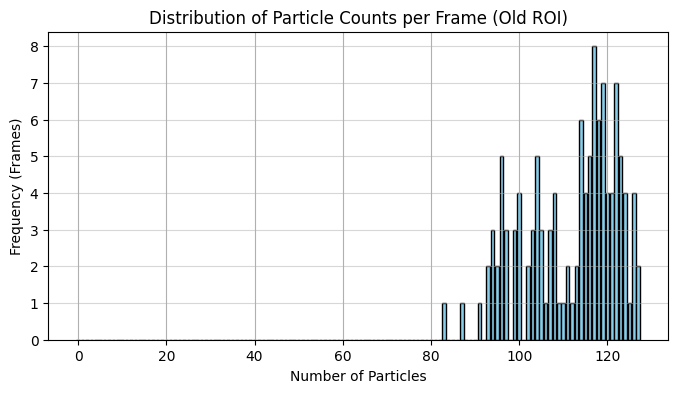

In [ ]:
import pandas as pd
import numpy as np

# 1. Define Old ROI (as seen in previous cells)
old_roi_x_min, old_roi_x_max = 256, 512
old_roi_y_min, old_roi_y_max = 512, 768

# 2. Load Ground Truth Data
gt_df = pd.read_csv('/content/val_data/val.csv')

# 3. Filter for Old ROI
gt_old_roi = gt_df[
    (gt_df['x'] >= old_roi_x_min) & (gt_df['x'] < old_roi_x_max) &
    (gt_df['y'] >= old_roi_y_min) & (gt_df['y'] < old_roi_y_max)
]

# 4. Count particles per frame
# Ensure we account for frames with 0 detections by reindexing against the full video range
total_frames = len(video_stack)
frame_counts = gt_old_roi.groupby('frame').size().reindex(range(total_frames), fill_value=0)

# 5. Calculate Statistics
stats_df = pd.DataFrame({
    'Statistic': ['Mean', 'Std Dev', 'Median'],
    'Value': [frame_counts.mean(), frame_counts.std(), frame_counts.median()]
})

print(f"📊 Ground Truth Statistics for OLD ROI (X:[{old_roi_x_min}:{old_roi_x_max}], Y:[{old_roi_y_min}:{old_roi_y_max}])")
display(stats_df)

# Optional: Show a quick histogram
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
frame_counts.hist(bins=range(int(frame_counts.max())+2), align='left', rwidth=0.8, color='skyblue', edgecolor='black')
plt.title("Distribution of Particle Counts per Frame (Old ROI)")
plt.xlabel("Number of Particles")
plt.ylabel("Frequency (Frames)")
plt.grid(axis='y', alpha=0.5)
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# 1. Define the ROI boundaries
roi_x_min, roi_x_max = 384, 640
roi_y_min, roi_y_max = 128, 384

# 2. Initialize an empty list
annotated_training_data = []

print(f"Processing {len(video_stack)} frames to generate annotated training data...")

# 3. Iterate through each frame index
for i in range(len(video_stack)):
    # 4. Extract the crop
    crop = video_stack[i][roi_y_min:roi_y_max, roi_x_min:roi_x_max]

    # 5. Filter the gt_df DataFrame
    frame_gt = gt_df[
        (gt_df['frame'] == i) &
        (gt_df['x'] >= roi_x_min) & (gt_df['x'] < roi_x_max) &
        (gt_df['y'] >= roi_y_min) & (gt_df['y'] < roi_y_max)
    ].copy()

    # 6. Create a list of relative coordinates
    # Subtract ROI offset to get local coordinates
    frame_gt['x'] = frame_gt['x'] - roi_x_min
    frame_gt['y'] = frame_gt['y'] - roi_y_min

    # Convert to list of dictionaries
    points = frame_gt[['x', 'y']].to_dict('records')

    # 7. Construct dictionary for current frame
    sample = {
        'image': crop,
        'points': points
    }

    # 8. Append to list
    annotated_training_data.append(sample)

print(f"Successfully generated `annotated_training_data` with {len(annotated_training_data)} samples.")

# Quick verification of the first sample
if len(annotated_training_data) > 0:
    print(f"Sample 0 Image Shape: {annotated_training_data[0]['image'].shape}")
    print(f"Sample 0 Points Count: {len(annotated_training_data[0]['points'])}")

Processing 120 frames to generate annotated training data...
Successfully generated `annotated_training_data` with 120 samples.
Sample 0 Image Shape: (256, 256)
Sample 0 Points Count: 0


Training Loader created with 120 samples.


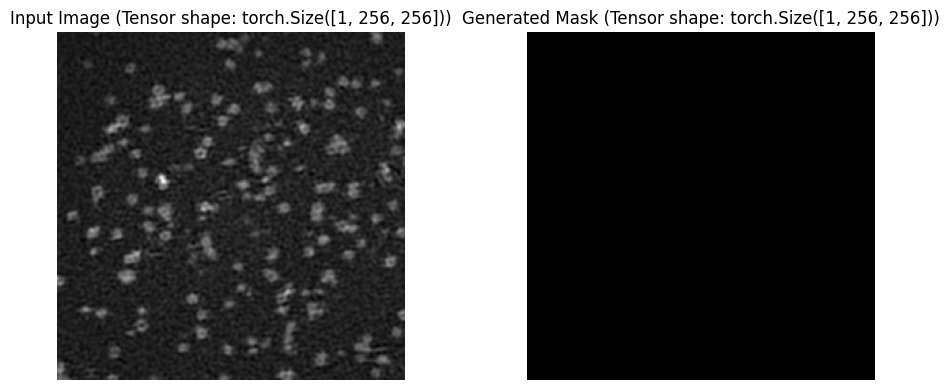

In [ ]:
# @title Create Dataset & DataLoader (From Annotated Data)
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import matplotlib.pyplot as plt

class MicroscopyDataset(Dataset):
    def __init__(self, data_list, transform=None, mask_radius=3):
        """
        Args:
            data_list (list): The 'annotated_training_data' list of dicts.
            transform (callable, optional): Augmentations.
            mask_radius (int): Radius of the dot to draw for each point.
        """
        self.data = data_list
        self.transform = transform
        self.mask_radius = mask_radius

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]

        # 1. Get Image
        # Ensure it's in a standard format (H, W) or (H, W, C)
        image = sample['image']

        # Normalize Image (0-255 -> 0.0-1.0)
        if image.dtype != np.float32:
            image = image.astype(np.float32) / 255.0

        # 2. Generate Mask from Points
        # We start with a black background
        mask = np.zeros(image.shape[:2], dtype=np.float32)

        points = sample['points']
        for p in points:
            # Draw a white circle for every ground truth point
            # usage: cv2.circle(img, center, radius, color, thickness)
            # thickness=-1 fills the circle
            cx, cy = int(round(p['x'])), int(round(p['y']))

            # Boundary check to prevent crashing cv2
            if 0 <= cx < mask.shape[1] and 0 <= cy < mask.shape[0]:
                cv2.circle(mask, (cx, cy), self.mask_radius, 1.0, -1)

        # 3. Add Channel Dimension (Standard for PyTorch: C, H, W)
        # If image is grayscale (H, W), make it (1, H, W)
        if len(image.shape) == 2:
            image = np.expand_dims(image, axis=0)

        mask = np.expand_dims(mask, axis=0) # (1, H, W)

        # 4. Convert to Tensor
        image_tensor = torch.from_numpy(image)
        mask_tensor = torch.from_numpy(mask)

        return image_tensor, mask_tensor

# ---------------------------------------------------------
# SETUP DATALOADERS
# ---------------------------------------------------------

# 1. Initialize Dataset
# Use a radius that matches your typical cell size (e.g., 3px radius = 6px wide dot)
train_dataset = MicroscopyDataset(annotated_training_data, mask_radius=3)

# 2. Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

print(f"Training Loader created with {len(train_dataset)} samples.")

# ---------------------------------------------------------
# VISUAL VERIFICATION (Sanity Check)
# ---------------------------------------------------------
# Let's pull one batch to make sure the masks look correct
images, masks = next(iter(train_loader))

plt.figure(figsize=(10, 4))

# Show Image
plt.subplot(1, 2, 1)
plt.imshow(images[0].squeeze(), cmap='gray')
plt.title(f"Input Image (Tensor shape: {images[0].shape})")
plt.axis('off')

# Show Generated Mask
plt.subplot(1, 2, 2)
plt.imshow(masks[0].squeeze(), cmap='gray')
plt.title(f"Generated Mask (Tensor shape: {masks[0].shape})")
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import torch
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy.ndimage import center_of_mass
import matplotlib.pyplot as plt
from transformers import Sam3Processor, Sam3Model # Assuming these are available from the install

# ---------------------------------------------------------
# 1. CONFIGURATION
# ---------------------------------------------------------
# ROI Boundaries
roi_x_min, roi_x_max = 384, 640
roi_y_min, roi_y_max = 128, 384

# SAM 3 Parameters
BEST_CONF = 0.3
BEST_AREA = 5
BEST_NMS  = 0.0
BEST_PIX  = 40
BORDER_M  = 3

# --- FRAME SELECTION ---
# Since the new ROI is spatially distinct from the original validation data,
# we can use any frame. We sample randomly from the available training data.
all_indices = list(range(len(annotated_training_data)))
N_SAMPLES = 20

frames_to_annotate = np.random.choice(all_indices, min(N_SAMPLES, len(all_indices)), replace=False)
frames_to_annotate.sort()

print(f"✅ Selected {len(frames_to_annotate)} frames for annotation: {frames_to_annotate}")

# ---------------------------------------------------------
# 2. HELPER FUNCTION: Process & Split Masks
# ---------------------------------------------------------
def process_and_split_mask(sam_mask, score, crop_uint8, min_area, pixel_thresh, border_margin=10):
    """
    Splits fused masks, filters by Area + Intensity, AND removes edge artifacts.
    """
    valid_points = []
    if sam_mask.sum() <= 0: return []

    h, w = crop_uint8.shape[:2]

    # Distance Transform & Watershed for splitting fused blobs
    distance = ndi.distance_transform_edt(sam_mask)
    # peak_local_max requires a min_distance to separate peaks
    coords = peak_local_max(distance, min_distance=3, labels=sam_mask)

    mask_peaks = np.zeros(distance.shape, dtype=bool)
    mask_peaks[tuple(coords.T)] = True
    markers, _ = ndi.label(mask_peaks)

    labels = watershed(-distance, markers, mask=sam_mask)

    for label_id in np.unique(labels):
        if label_id == 0: continue

        sub_mask = (labels == label_id)

        # A. Area Filter
        if sub_mask.sum() < min_area: continue

        # B. Get Center
        y, x = center_of_mass(sub_mask)
        if np.isnan(x) or np.isnan(y): continue

        # C. Border Filter
        if (x < border_margin) or (x > w - border_margin) or \
           (y < border_margin) or (y > h - border_margin):
            continue

        # D. Intensity Filter
        y_int, x_int = int(y), int(x)
        if 0 <= y_int < h and 0 <= x_int < w:
            brightness = crop_uint8[y_int, x_int]
            if brightness < pixel_thresh:
                continue

        valid_points.append({'x': x, 'y': y, 'score': score})

    return valid_points

✅ Selected 20 frames for annotation: [  9  15  17  18  20  25  45  48  49  60  68  80  81  88  91  96  97 100
 115 116]


⚙️ Loading SAM 3 Model (Facebook/SAM3)...


processor_config.json:   0%|          | 0.00/1.71k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/799 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.64M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/25.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/1468 [00:00<?, ?it/s]

✅ Model loaded successfully.
⚡ Running High-Res Inference (Scale 2.0x) across 4 prompts...


Inference:   0%|          | 0/40 [00:00<?, ?it/s]

🚀 Sweeping 12 params on High-Res Data...


Optimizing:   0%|          | 0/12 [00:00<?, ?it/s]


🏆 HIGH-RES PIPELINE RESULT (Scale 2.0x)
Best Avg DetA:  0.6595
Best Prompt:    'dots'
Erosion Iter:   2
Min Dist (HR):  6
Intensity (HR): 30


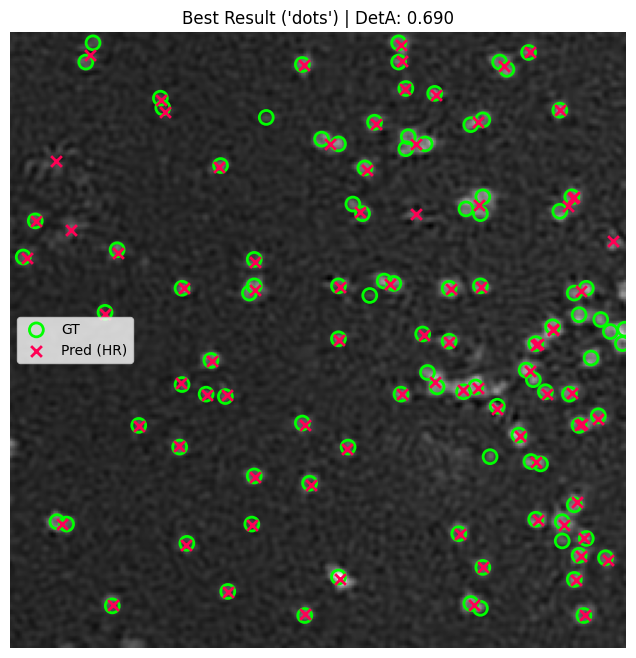

In [ ]:
# @title High-Res Pipeline (Upscaling + CLAHE + Prompt Sweep) [FIXED]

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import torch
import itertools
from PIL import Image
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from scipy.ndimage import center_of_mass
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from transformers import Sam3Processor, Sam3Model
from tqdm.notebook import tqdm
import tifffile
import os

# ---------------------------------------------------------
# 1. CONFIGURATION
# ---------------------------------------------------------
# Same Frames
SWEEP_FRAMES = np.linspace(0, 49, 10, dtype=int).tolist()
roi_x_min, roi_x_max = 256, 512
roi_y_min, roi_y_max = 512, 768

# --- THE MAGIC PARAMETERS ---
SCALE_FACTOR = 2.0  # <--- The key to beating the benchmark

# Adjusted Sweep Params for the 2x Scale
EROSION_RANGE = [2]       # Aggressive erosion on large masks
MIN_DIST_RANGE = [6]      # Separation in "Big Pixel" space
PIXEL_THRESH_RANGE = [25, 30, 35]

# NEW: Text Prompt Sweep
TEXT_PROMPT_RANGE = ["dots", "small white dots", "particles", "cells"]

# Fixed
FIXED_CONF = 0.25
BORDER_MARGIN = 5 * SCALE_FACTOR # Scale the margin too
MATCH_THRESH = 5.0 # Evaluation tolerance

# ---------------------------------------------------------
# 1.5 INITIALIZE MODEL (The Missing Part)
# ---------------------------------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

if 'model' not in globals() or 'processor' not in globals():
    print("⚙️ Loading SAM 3 Model (Facebook/SAM3)...")
    try:
        processor = Sam3Processor.from_pretrained("facebook/sam3")
        model = Sam3Model.from_pretrained("facebook/sam3").to(device)
        print("✅ Model loaded successfully.")
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        print("Tip: Make sure you are logged into Hugging Face if using a gated model.")
else:
    print("✅ Model already loaded in memory.")

# Check for data
tiff_path = "/content/val_data/val.tif"
if 'video_stack' not in globals():
    if os.path.exists(tiff_path):
        video_stack = tifffile.imread(tiff_path)
    else:
        # Create dummy if file missing (just so code compiles)
        print("⚠️ Data file not found. Creating dummy stack.")
        video_stack = np.zeros((100, 1024, 1024), dtype=np.uint8)

gt_df = pd.read_csv('/content/val_data/val.csv')

# ---------------------------------------------------------
# 2. HELPER: PRE-PROCESSING
# ---------------------------------------------------------
def preprocess_high_res(crop_img):
    """Upscales and applies CLAHE contrast enhancement."""
    # 1. Norm to 0-255 uint8
    if crop_img.dtype != np.uint8:
        img_norm = (crop_img - crop_img.min()) / (crop_img.max() - crop_img.min())
        img_uint8 = (img_norm * 255).astype(np.uint8)
    else:
        img_uint8 = crop_img

    # 2. CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8,8))
    img_clahe = clahe.apply(img_uint8)

    # 3. Super-Resolution (Upscale)
    h, w = img_clahe.shape
    new_size = (int(w * SCALE_FACTOR), int(h * SCALE_FACTOR))
    img_large = cv2.resize(img_clahe, new_size, interpolation=cv2.INTER_CUBIC)

    return img_large, img_uint8

# ---------------------------------------------------------
# 3. PRE-COMPUTATION (Run SAM on 2x Images with Multiple Prompts)
# ---------------------------------------------------------
print(f"⚡ Running High-Res Inference (Scale {SCALE_FACTOR}x) across {len(TEXT_PROMPT_RANGE)} prompts...")
cached_data = []

inference_combos = list(itertools.product(SWEEP_FRAMES, TEXT_PROMPT_RANGE))

for frame_idx, prompt_text in tqdm(inference_combos, desc="Inference"):
    raw_frame = video_stack[frame_idx]
    crop = raw_frame[roi_y_min:roi_y_max, roi_x_min:roi_x_max]

    # Get the "Big" image
    img_large, img_original = preprocess_high_res(crop)
    image_rgb_large = Image.fromarray(img_large).convert("RGB")

    # Run SAM on the BIG image with the CURRENT prompt
    inputs = processor(images=image_rgb_large, text=prompt_text, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)

    res = processor.post_process_instance_segmentation(
        outputs, threshold=FIXED_CONF, target_sizes=[image_rgb_large.size[::-1]]
    )[0]

    cached_data.append({
        'frame_idx': frame_idx,
        'prompt': prompt_text,  # Store which prompt generated this
        'masks': res['masks'].cpu().numpy(),
        'scores': res['scores'].cpu().numpy(),
        'img_large': img_large,
        'img_orig': img_original
    })

# ---------------------------------------------------------
# 4. SWEEP LOGIC (Updated for Scaling)
# ---------------------------------------------------------
def process_high_res_batch(masks, scores, img_large, erosion_iter, min_dist, pixel_thresh):
    valid_points = []
    h, w = img_large.shape[:2]

    for m, s in zip(masks, scores):
        # 1. Erosion (On Large Mask)
        mask_uint8 = m.astype(np.uint8)
        if erosion_iter > 0:
            kernel = np.ones((3,3), np.uint8)
            mask_uint8 = cv2.erode(mask_uint8, kernel, iterations=erosion_iter)

        if mask_uint8.sum() == 0: continue

        # 2. Distance & Peaks
        bool_mask = mask_uint8 > 0
        distance = ndi.distance_transform_edt(bool_mask)
        coords = peak_local_max(distance, min_distance=min_dist, labels=bool_mask)

        mask_peaks = np.zeros(distance.shape, dtype=bool)
        mask_peaks[tuple(coords.T)] = True
        markers, _ = ndi.label(mask_peaks)

        # 3. Watershed
        labels = watershed(-distance, markers, mask=bool_mask)

        # 4. Filtering
        for label_id in np.unique(labels):
            if label_id == 0: continue
            sub_mask = (labels == label_id)

            y, x = center_of_mass(sub_mask)
            if np.isnan(x) or np.isnan(y): continue

            # Border Check (In Large Coordinates)
            if (x < BORDER_MARGIN) or (x > w - BORDER_MARGIN) or \
               (y < BORDER_MARGIN) or (y > h - BORDER_MARGIN):
                continue

            # Intensity Check (In Large Image)
            y_int, x_int = int(y), int(x)
            if 0 <= y_int < h and 0 <= x_int < w:
                if img_large[y_int, x_int] < pixel_thresh: continue

            # Scale coordinates back down
            valid_points.append({'x': x / SCALE_FACTOR, 'y': y / SCALE_FACTOR})

    return np.array([[d['x'], d['y']] for d in valid_points])

# ---------------------------------------------------------
# 5. EXECUTE SWEEP
# ---------------------------------------------------------
combinations = list(itertools.product(TEXT_PROMPT_RANGE, EROSION_RANGE, MIN_DIST_RANGE, PIXEL_THRESH_RANGE))
results_log = []

def calculate_deta(gt_coords, pred_coords, threshold=5.0):
    if len(gt_coords) == 0 and len(pred_coords) == 0: return 1.0
    if len(gt_coords) == 0 or len(pred_coords) == 0: return 0.0
    dists = cdist(gt_coords, pred_coords)
    sims = 1 - (dists / threshold)
    sims[sims < 0] = 0
    row_ind, col_ind = linear_sum_assignment(-sims)
    tp = sum(1 for r, c in zip(row_ind, col_ind) if sims[r, c] > 0)
    denom = (len(gt_coords) + len(pred_coords)) - tp
    return tp / denom if denom > 0 else 0.0

print(f"🚀 Sweeping {len(combinations)} params on High-Res Data...")

for prompt_txt, ero, dist, pix in tqdm(combinations, desc="Optimizing"):
    total_deta = 0.0

    current_prompt_cache = [item for item in cached_data if item['prompt'] == prompt_txt]

    for item in current_prompt_cache:
        pred_local = process_high_res_batch(
            item['masks'], item['scores'], item['img_large'],
            erosion_iter=ero, min_dist=dist, pixel_thresh=pix
        )
        gt_subset = gt_df[(gt_df['frame'] == item['frame_idx']) &
                          (gt_df['x'].between(roi_x_min, roi_x_max)) &
                          (gt_df['y'].between(roi_y_min, roi_y_max))]
        gt_local = gt_subset[['x', 'y']].values - np.array([roi_x_min, roi_y_min])
        total_deta += calculate_deta(gt_local, pred_local, threshold=MATCH_THRESH)

    avg_deta = total_deta / len(current_prompt_cache)
    results_log.append({
        'Prompt': prompt_txt,
        'Erosion': ero,
        'Min_Dist': dist,
        'Pixel_Thresh': pix,
        'Avg_DetA': avg_deta
    })

# ---------------------------------------------------------
# 6. RESULTS
# ---------------------------------------------------------
res_df = pd.DataFrame(results_log)
best_run = res_df.loc[res_df['Avg_DetA'].idxmax()]

print("\n" + "="*40)
print(f"🏆 HIGH-RES PIPELINE RESULT (Scale {SCALE_FACTOR}x)")
print("="*40)
print(f"Best Avg DetA:  {best_run['Avg_DetA']:.4f}")
print(f"Best Prompt:    '{best_run['Prompt']}'")
print(f"Erosion Iter:   {int(best_run['Erosion'])}")
print(f"Min Dist (HR):  {int(best_run['Min_Dist'])}")
print(f"Intensity (HR): {int(best_run['Pixel_Thresh'])}")

best_prompt = best_run['Prompt']
best_ero = int(best_run['Erosion'])
best_dist = int(best_run['Min_Dist'])
best_pix = int(best_run['Pixel_Thresh'])

item = next(x for x in cached_data if x['frame_idx'] == SWEEP_FRAMES[5] and x['prompt'] == best_prompt)

pred_local = process_high_res_batch(item['masks'], item['scores'], item['img_large'], best_ero, best_dist, best_pix)
gt_subset = gt_df[(gt_df['frame'] == item['frame_idx']) &
                  (gt_df['x'].between(roi_x_min, roi_x_max)) &
                  (gt_df['y'].between(roi_y_min, roi_y_max))]
gt_local = gt_subset[['x', 'y']].values - np.array([roi_x_min, roi_y_min])

plt.figure(figsize=(8,8))
plt.imshow(item['img_orig'], cmap='gray')
if len(gt_local) > 0: plt.scatter(gt_local[:,0], gt_local[:,1], s=100, facecolors='none', edgecolors='#00FF00', lw=2, label='GT')
if len(pred_local) > 0: plt.scatter(pred_local[:,0], pred_local[:,1], c='#FF0055', marker='x', s=60, lw=2, label='Pred (HR)')
plt.legend()
plt.title(f"Best Result ('{best_prompt}') | DetA: {calculate_deta(gt_local, pred_local):.3f}")
plt.axis('off')
plt.show()

✅ Model already loaded.
🚀 Processing 120 frames in batches...


Inference Pipeline:   0%|          | 0/120 [00:00<?, ?it/s]

✅ Processing Complete.
   - Saved 14858 points to CSV
   - Saved 120 images to 'processed_annotation_data'

👀 Previewing first 20 frames (Rows of 5)...


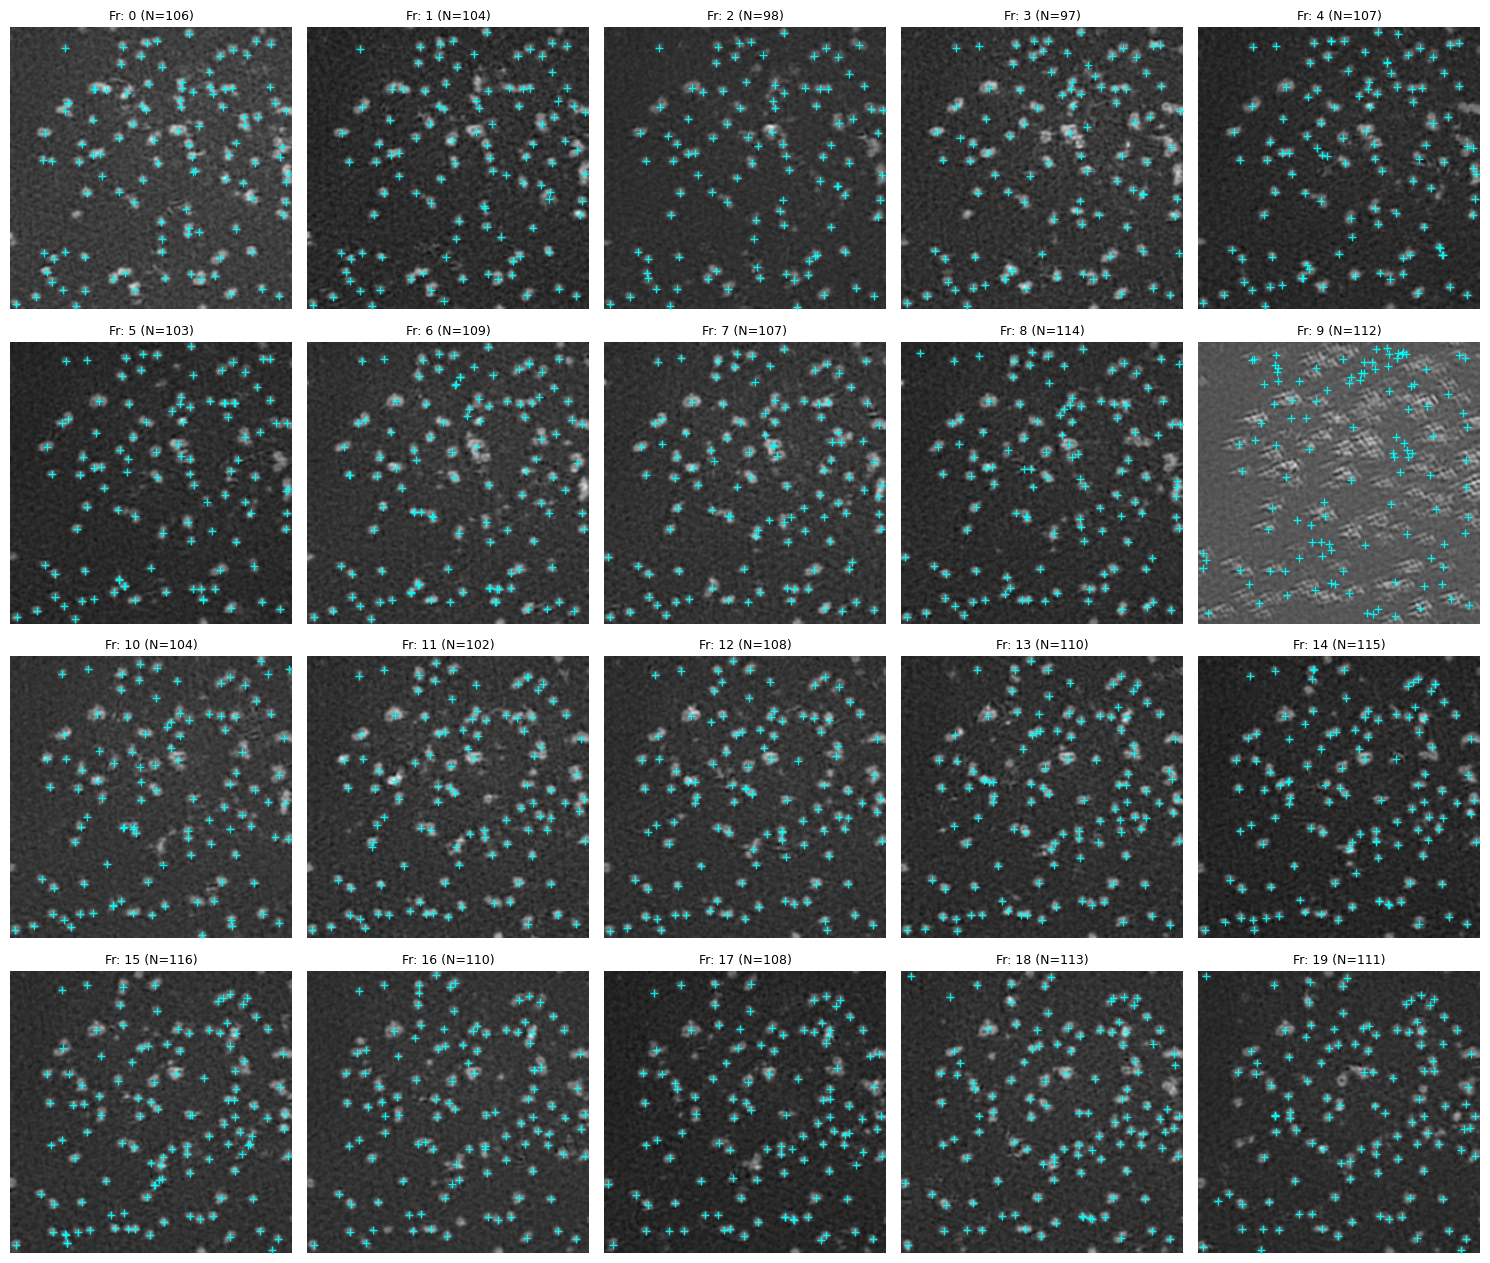

📦 Zipping data...
⬇️ Triggering download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# @title 🚀 Batched High-Res Pipeline (T4 Optimized)
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
import pandas as pd
from PIL import Image
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy.ndimage import center_of_mass
from transformers import Sam3Processor, Sam3Model
from tqdm.notebook import tqdm
import os
import shutil
import gc
from google.colab import files

# ---------------------------------------------------------
# 1. CONFIGURATION & MEMORY SETTINGS
# ---------------------------------------------------------
SCALE_FACTOR = 2.0
BEST_PROMPT  = "dots"
BEST_CONF    = 0.25
BEST_EROSION = 2
BEST_DIST_HR = 6
BEST_PIX_HR  = 40
BORDER_MARGIN = 3 * SCALE_FACTOR

# T4 Optimization: Process in chunks to clear VRAM frequently
BATCH_SIZE = 1  # 512x512 inference is fast; batch=1 is safest for loop logic
VISUALIZATION_LIMIT = 20 # Only plot this many to avoid browser crash

EXPORT_DIR = "processed_annotation_data"
if os.path.exists(EXPORT_DIR): shutil.rmtree(EXPORT_DIR)
os.makedirs(EXPORT_DIR)

# ---------------------------------------------------------
# 2. HELPER FUNCTIONS
# ---------------------------------------------------------
def preprocess_high_res(crop_img):
    """Upscales and applies CLAHE contrast enhancement with Denoising."""
    if crop_img.dtype != np.uint8:
        img_norm = (crop_img - crop_img.min()) / (crop_img.max() - crop_img.min())
        img_uint8 = (img_norm * 255).astype(np.uint8)
    else:
        img_uint8 = crop_img

    img_uint8 = cv2.GaussianBlur(img_uint8, (3, 3), 0)
    clahe = cv2.createCLAHE(clipLimit=1.2, tileGridSize=(8,8))
    img_clahe = clahe.apply(img_uint8)

    h, w = img_clahe.shape
    new_size = (int(w * SCALE_FACTOR), int(h * SCALE_FACTOR))
    img_large = cv2.resize(img_clahe, new_size, interpolation=cv2.INTER_CUBIC)

    return img_large, img_uint8

def process_high_res_mask(sam_mask, score, img_large):
    valid_points = []
    h, w = img_large.shape[:2]

    mask_uint8 = sam_mask.astype(np.uint8)
    if BEST_EROSION > 0:
        kernel = np.ones((3,3), np.uint8)
        mask_uint8 = cv2.erode(mask_uint8, kernel, iterations=BEST_EROSION)

    if mask_uint8.sum() == 0: return []

    bool_mask = mask_uint8 > 0
    distance = ndi.distance_transform_edt(bool_mask)
    coords = peak_local_max(distance, min_distance=BEST_DIST_HR, labels=bool_mask)

    mask_peaks = np.zeros(distance.shape, dtype=bool)
    mask_peaks[tuple(coords.T)] = True
    markers, _ = ndi.label(mask_peaks)
    labels = watershed(-distance, markers, mask=bool_mask)

    for label_id in np.unique(labels):
        if label_id == 0: continue
        sub_mask = (labels == label_id)

        y, x = center_of_mass(sub_mask)
        if np.isnan(x) or np.isnan(y): continue

        if (x < BORDER_MARGIN) or (x > w - BORDER_MARGIN) or \
           (y < BORDER_MARGIN) or (y > h - BORDER_MARGIN): continue

        y_int, x_int = int(y), int(x)
        if 0 <= y_int < h and 0 <= x_int < w:
            if img_large[y_int, x_int] < BEST_PIX_HR: continue

        valid_points.append({
            'x': x / SCALE_FACTOR,
            'y': y / SCALE_FACTOR,
            'score': score
        })

    return valid_points

# ---------------------------------------------------------
# 3. INITIALIZE MODEL
# ---------------------------------------------------------
if 'model' not in globals():
    print("⚙️ Loading SAM 3 Model...")
    MODEL_ID = "facebook/sam3"
    device = "cuda" if torch.cuda.is_available() else "cpu"
    try:
        processor = Sam3Processor.from_pretrained(MODEL_ID)
        model = Sam3Model.from_pretrained(MODEL_ID).to(device)
        print("✅ Model loaded.")
    except Exception as e:
        print(f"❌ Error loading model: {e}")
else:
    print("✅ Model already loaded.")

# ---------------------------------------------------------
# 4. STREAMING BATCH PROCESSING
# ---------------------------------------------------------
frames_to_process = list(range(len(annotated_training_data)))
csv_rows = []
preview_data = [] # Store a few for visualization

print(f"🚀 Processing {len(frames_to_process)} frames in batches...")

# We iterate 1 by 1 for safety, but clear memory periodically
for i, idx in enumerate(tqdm(frames_to_process, desc="Inference Pipeline")):

    with torch.no_grad():
        # A. LOAD DATA
        sample_data = annotated_training_data[idx]
        crop_raw = sample_data['image']

        # FIX: Use idx as fallback if 'frame_index' is missing to ensure unique filenames
        real_frame_num = sample_data.get('frame_index', idx)

        # B. PREPROCESS
        img_large, img_orig_uint8 = preprocess_high_res(crop_raw)
        image_rgb_large = Image.fromarray(img_large).convert("RGB")

        # C. INFERENCE
        inputs = processor(images=image_rgb_large, text=BEST_PROMPT, return_tensors="pt").to(device)
        outputs = model(**inputs)

        res = processor.post_process_instance_segmentation(
            outputs, threshold=0.01, target_sizes=[image_rgb_large.size[::-1]]
        )[0]

        # D. POST-PROCESS
        frame_points = []
        scores = res['scores'].cpu().numpy()
        masks = res['masks'].cpu().numpy()

        for k, score in enumerate(scores):
            if score < BEST_CONF: continue
            points = process_high_res_mask(masks[k], score, img_large)
            frame_points.extend(points)

        # E. SAVE IMMEDIATELY (Don't keep heavy images in RAM)
        img_filename = f"frame_{real_frame_num:04d}.png"
        cv2.imwrite(os.path.join(EXPORT_DIR, img_filename), img_orig_uint8)

        # F. LOG METADATA
        for p in frame_points:
            csv_rows.append({
                'filename': img_filename,
                'frame': real_frame_num,
                'x': p['x'],
                'y': p['y'],
                'score': p['score']
            })

        # G. UPDATE PREVIEW (Only keep first N images in RAM)
        if len(preview_data) < VISUALIZATION_LIMIT:
            preview_data.append({
                'image': img_orig_uint8, # Keep uint8 (lightweight)
                'points': frame_points,
                'real_frame': real_frame_num
            })

    # H. MEMORY CLEANUP
    if i % 10 == 0:
        torch.cuda.empty_cache()
        gc.collect()

# Save final CSV
csv_path = os.path.join(EXPORT_DIR, "auto_annotations.csv")
pd.DataFrame(csv_rows).to_csv(csv_path, index=False)
print(f"✅ Processing Complete.")
print(f"   - Saved {len(csv_rows)} points to CSV")
print(f"   - Saved {len(frames_to_process)} images to '{EXPORT_DIR}'")

# ---------------------------------------------------------
# 5. GRID VISUALIZATION
# ---------------------------------------------------------
print(f"\n👀 Previewing first {len(preview_data)} frames (Rows of 5)...")

cols = 5
rows = (len(preview_data) + cols - 1) // cols

if len(preview_data) > 0:
    # Calculate figsize dynamically based on number of rows
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3.2))
    # Ensure axes is always iterable even if 1 row
    if rows == 1 and cols == 1: axes = np.array([axes])
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < len(preview_data):
            sample = preview_data[i]
            img = sample['image']
            pts = sample['points']

            ax.imshow(img, cmap='gray', vmin=0, vmax=255)

            if pts:
                xs = [p['x'] for p in pts]
                ys = [p['y'] for p in pts]
                ax.scatter(xs, ys, c='cyan', marker='+', s=40, linewidth=1, alpha=0.9)

            ax.set_title(f"Fr: {sample['real_frame']} (N={len(pts)})", fontsize=9)
        else:
            ax.axis('off')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------
# 6. DOWNLOAD
# ---------------------------------------------------------
print("📦 Zipping data...")
shutil.make_archive("annotation_data", 'zip', EXPORT_DIR)

print("⬇️ Triggering download...")
files.download("annotation_data.zip")